In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import geopandas as gpd

In [27]:
df = pd.read_csv('data/processed/processed_data.csv')
df['timestamp'] = df['bin'] + 288*df['day'] + 31*288*df['month']

In [ ]:
df.head()

,zone,bin,day,month,time_period,demand,air_temp,air_temp_feel,rain,snow,residential,education,recreational,commercial,health,subway_stations,bus_stops,avg_demand_five,historical_average,timestamp
0,4,0,3,6,off_peak,7.0,73.18,73.31,0.0,0.0,57,11,30,0,1,0.0,11.0,NaN,6.052632,54432
1,4,1,3,6,off_peak,5.0,73.18,73.31,0.0,0.0,57,11,30,0,1,0.0,11.0,NaN,4.315789,54433
2,4,2,3,6,off_peak,1.0,73.18,73.31,0.0,0.0,57,11,30,0,1,0.0,11.0,NaN,4.473684,54434
3,4,3,3,6,off_peak,3.0,73.18,73.31,0.0,0.0,57,11,30,0,1,0.0,11.0,NaN,3.631579,54435
4,4,4,3,6,off_peak,1.0,73.18,73.31,0.0,0.0,57,11,30,0,1,0.0,11.0,3.4,4.631579,54436


In [3]:
zone_id = df['zone'].unique()

### Demand deviation

Process the demand into the deviation from the same time of the previous week.

In [ ]:
def pre_demand(row,df):
    pre_demand = df[(df['bin']==row['bin'])&(df['day']==row['day']-7)]['demand'].values
    if len(pre_demand)==0:
        return None
    else:
        return pre_demand[0]

def demand_diff(df, res):
    
    df['demand_ref'] = df.apply(lambda x:pre_demand(x,df),axis=1)
    res.append(df)

In [ ]:
res = []
_ = df.groupby('zone').apply(lambda df:demand_diff(df,res))

In [ ]:
df_temp = pd.concat(res)
df_temp.head()

,zone,bin,day,month,time_period,demand,air_temp,air_temp_feel,rain,snow,...,education,recreational,commercial,health,subway_stations,bus_stops,avg_demand_five,historical_average,timestamp,demand_ref
0,4,0,3,6,off_peak,7.0,73.18,73.31,0.0,0.0,...,11,30,0,1,0.0,11.0,NaN,6.052632,54432,NaN
1,4,1,3,6,off_peak,5.0,73.18,73.31,0.0,0.0,...,11,30,0,1,0.0,11.0,NaN,4.315789,54433,NaN
2,4,2,3,6,off_peak,1.0,73.18,73.31,0.0,0.0,...,11,30,0,1,0.0,11.0,NaN,4.473684,54434,NaN
3,4,3,3,6,off_peak,3.0,73.18,73.31,0.0,0.0,...,11,30,0,1,0.0,11.0,NaN,3.631579,54435,NaN
4,4,4,3,6,off_peak,1.0,73.18,73.31,0.0,0.0,...,11,30,0,1,0.0,11.0,3.4,4.631579,54436,NaN


In [ ]:
df = df_temp.dropna()
df['demand_diff'] = df['demand'] - df['demand_ref']

C:\Users\11481\AppData\Local\Temp\ipykernel_13200\549742825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['demand_diff'] = df['demand'] - df['demand_ref']


In [ ]:
df.drop(['demand'],axis=1,inplace=True)
df.rename(columns={'demand_diff':'demand'},inplace=True)

C:\Users\11481\AppData\Local\Temp\ipykernel_13200\1108352270.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['demand'],axis=1,inplace=True)
C:\Users\11481\AppData\Local\Temp\ipykernel_13200\1108352270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'demand_diff':'demand'},inplace=True)


### Demand

In [29]:
df = df[(df['timestamp']>=61628)]
df_demand = df[['zone','month','day','bin','demand','timestamp']]
df_demand = df_demand.sort_values(by=['month','day','bin','zone'])
df_demand.head(10)

,zone,month,day,bin,demand,timestamp
5468,4,6,27,284,7.0,61628
11228,12,6,27,284,0.0,61628
16988,13,6,27,284,12.0,61628
22748,24,6,27,284,4.0,61628
28508,41,6,27,284,14.0,61628
34268,42,6,27,284,15.0,61628
40028,43,6,27,284,1.0,61628
45788,45,6,27,284,6.0,61628
51548,48,6,27,284,48.0,61628
57308,50,6,27,284,15.0,61628


In [30]:
def combine(df_demand,df,x,y,timestamp,included,lookback=2):
    df = df.sort_values('zone')
    time = df['timestamp'].values[0]
    if (time-lookback) in included:
        timestamp.append(time)

        feature_time = [time-i for i in reversed(range(1,lookback+1))]
        pre_demand = df_demand.loc[(df_demand['timestamp'].isin(feature_time))]

        features = pre_demand.groupby(['zone'])['demand'].agg(lambda x:x.tolist()).to_list()
        labels = df['demand'].to_list()
        
        x.append(features)
        y.append(labels)

In [31]:
included = df_demand['timestamp'].unique()
timestamp = []
x = []
y = []
_ = df_demand.groupby('timestamp').apply(lambda df:combine(df_demand,df,x,y,timestamp,included))

In [32]:
x_new = []
y_new = []
timestamp_new = []
for i, time in enumerate(timestamp):
    temp_x = []
    if (time-2) in timestamp:
        temp_x.append(x[i-2])
        temp_x.append(x[i-1])
        x_new.append(temp_x)
        y_new.append(y[i])
        timestamp_new.append(time)

In [33]:
len(x_new)

288

In [34]:
len(y_new)

288

In [35]:
x = np.array(x_new)
y = np.array(y_new)

In [36]:
len(timestamp_new)

288

In [37]:
x.shape

(288, 2, 63, 2)

In [ ]:
np.save('data/processed/0620x_diff.npy',x)
np.save('data/processed/0620y_diff.npy',y)

### Adjancent matrix

In [ ]:
zipfile = 'data/taxi_zones.shp'
zones = gpd.read_file(zipfile)
zones = zones.sort_values(['LocationID']).reset_index(drop=True)

In [ ]:
Manhattan = zones[zones['LocationID'].isin(zone_id)]
Manhattan.head(10)

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
11,12,0.036661,0.000042,Battery Park,12,Manhattan,"POLYGON ((979908.772 196066.565, 979980.852 19..."
12,13,0.050281,0.000149,Battery Park City,13,Manhattan,"POLYGON ((980801.310 201248.869, 980697.386 20..."
23,24,0.047000,0.000061,Bloomingdale,24,Manhattan,"POLYGON ((995453.114 230274.267, 995312.583 23..."
40,41,0.052793,0.000143,Central Harlem,41,Manhattan,"POLYGON ((998716.913 234240.397, 999458.736 23..."
41,42,0.092709,0.000264,Central Harlem North,42,Manhattan,"POLYGON ((1002413.191 243934.560, 1002388.021 ..."
42,43,0.099739,0.000380,Central Park,43,Manhattan,"POLYGON ((991852.973 217950.807, 991725.244 21..."
44,45,0.045907,0.000091,Chinatown,45,Manhattan,"POLYGON ((984941.821 199431.157, 984958.446 19..."
47,48,0.043747,0.000094,Clinton East,48,Manhattan,"POLYGON ((986694.313 214463.846, 986568.184 21..."
49,50,0.055748,0.000173,Clinton West,50,Manhattan,"POLYGON ((985170.372 221087.389, 985817.170 22..."


In [ ]:
zones_centroid = Manhattan['geometry'].centroid
zones_polygon = Manhattan['geometry']

#### Eculiden

In [ ]:
euc_dist = zones_centroid.apply(lambda x:zones_centroid.distance(x)).to_numpy().flatten()

In [ ]:
census_adj = pd.DataFrame(np.array([np.repeat(Manhattan['LocationID'].to_numpy(), len(Manhattan)),
                                    np.tile(Manhattan['LocationID'].to_numpy(), len(Manhattan)),
                                    euc_dist]).T, columns=['start_id','end_id','euc'])

In [ ]:
census_adj['start_id'] = census_adj['start_id'].astype(int)
census_adj['end_id'] = census_adj['end_id'].astype(int)

,start_id,end_id,euc
0,4,4,0.000000
1,4,12,13112.689481
2,4,13,11651.582885
3,4,24,28674.720866
4,4,41,30207.906231


### Connectivity

In [ ]:
touch = zones_polygon.apply(lambda x: zones_polygon.touches(x)).to_numpy(dtype=np.float32).flatten()

In [ ]:
census_adj['con'] = touch

In [ ]:
census_adj.head()

,start_id,end_id,euc,con
0,4,4,0.000000,0.0
1,4,12,13112.689481,0.0
2,4,13,11651.582885,0.0
3,4,24,28674.720866,0.0
4,4,41,30207.906231,0.0


### Functionality

In [ ]:
spatial = df[['zone','residential','education','recreational','commercial','health']].drop_duplicates()
s = spatial[['residential','education','recreational','commercial','health']]
for i in s.columns:
    s.loc[:,i] = s[i]/s[i].max()

C:\Users\11481\AppData\Local\Temp\ipykernel_6552\4293389756.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s.loc[:,i] = s[i]/s[i].max()


In [ ]:
n = len(s)
s1 = np.transpose(np.tile(s, (n,1,1)),(1,0,2))
s2 = np.tile(s, (n,1,1))
s3 = np.sum(np.sqrt((s1-s2)*(s1-s2)), axis=2)
s4 = s3[(s3 > 0)].min()/s3
s4 = s4.flatten()
s4[~np.isfinite(s4)] = 0

C:\Users\11481\AppData\Local\Temp\ipykernel_6552\1964729647.py:5: RuntimeWarning: divide by zero encountered in divide
  s4 = s3[(s3 > 0)].min()/s3


In [ ]:
func_adj = pd.DataFrame(np.array([np.repeat(spatial['zone'].to_numpy(), n), 
                       np.tile(spatial['zone'].to_numpy(), n),
                       s4]).T, columns=['start_id','end_id','func'])


In [ ]:
census_adj = pd.merge(census_adj, func_adj, on=['start_id', 'end_id'], how='left').fillna(0)

In [ ]:
census_adj.head()

,start_id,end_id,euc,con,func
0,4,4,0.000000,0.0,0.000000
1,4,12,13112.689481,0.0,0.042759
2,4,13,11651.582885,0.0,0.037645
3,4,24,28674.720866,0.0,0.046002
4,4,41,30207.906231,0.0,0.046256


In [ ]:
census_adj.to_csv('data/processed/adjlist.csv',index=False)

### History

In [38]:
history = df[['zone','month','day','bin','historical_average','timestamp']]
history = history[history['timestamp'].isin(timestamp_new)]
history = history.sort_values(by=['timestamp','zone'])
history.head()

,zone,month,day,bin,historical_average,timestamp
5472,4,6,28,0,6.052632,61632
11232,12,6,28,0,0.105263,61632
16992,13,6,28,0,5.368421,61632
22752,24,6,28,0,2.421053,61632
28512,41,6,28,0,9.842105,61632


In [39]:
his = np.array(history.groupby('timestamp')['historical_average'].agg(lambda x: x.to_list()).to_list())
# np.save('data/processed/history_diff.npy',his)

### Level of service

In [40]:
los = df[['zone','month','day','bin','subway_stations','bus_stops','timestamp']]
los = los[los['timestamp'].isin(timestamp_new)]
los = los.sort_values(by=['timestamp','zone'])
los['public'] = los['subway_stations'] + 0.2*los['bus_stops']
los.head()

,zone,month,day,bin,subway_stations,bus_stops,timestamp,public
5472,4,6,28,0,0.0,11.0,61632,2.2
11232,12,6,28,0,0.0,0.0,61632,0.0
16992,13,6,28,0,0.0,3.0,61632,0.6
22752,24,6,28,0,1.0,13.0,61632,3.6
28512,41,6,28,0,6.0,36.0,61632,13.2


In [41]:
losn = np.array(los.groupby('timestamp')['public'].agg(lambda x: x.to_list()).to_list())
# np.save('data/processed/los_diff.npy',losn)

### Weather

In [42]:
weather = df[['zone','month','day','bin','air_temp_feel','rain','timestamp']]
weather = weather[weather['timestamp'].isin(timestamp_new)]
weather = weather.sort_values(by=['timestamp','zone'])
weather.head()

,zone,month,day,bin,air_temp_feel,rain,timestamp
5472,4,6,28,0,84.7,0.0,61632
11232,12,6,28,0,84.7,0.0,61632
16992,13,6,28,0,84.7,0.0,61632
22752,24,6,28,0,84.7,0.0,61632
28512,41,6,28,0,84.7,0.0,61632


In [43]:
weather['weather'] = weather.apply(lambda row:[row['air_temp_feel'],row['rain']],axis=1)
wea = np.array(weather.groupby('timestamp')['weather'].agg(lambda x: x.to_list()).to_list())

In [ ]:
np.save('data/processed/weather_diff.npy',wea)

In [19]:
wea.shape

(284, 63, 2)

In [44]:
np.savez('data/processed/0628.npz',x=x_new,y=y_new,history=his,los=losn,weather=wea)

In [9]:
data = np.load('data/processed/0620.npz')

In [10]:
data['x'].shape

(5744, 2, 63, 2)

In [12]:
timestamp[:10]

[54434, 54435, 54436, 54437, 54438, 54439, 54440, 54441, 54442, 54443]

In [13]:
x = data['x']

In [22]:
x[0][1]

array([[ 5.,  1.],
       [ 0.,  0.],
       [ 2.,  1.],
       [ 0.,  1.],
       [ 5., 13.],
       [10., 14.],
       [ 1.,  0.],
       [ 2.,  2.],
       [17., 18.],
       [ 4.,  7.],
       [15., 10.],
       [11.,  7.],
       [ 8.,  9.],
       [20., 16.],
       [ 3.,  6.],
       [ 1.,  0.],
       [ 5.,  5.],
       [ 3.,  8.],
       [ 7.,  4.],
       [ 6., 11.],
       [10.,  8.],
       [13., 13.],
       [ 0.,  0.],
       [ 3.,  2.],
       [ 6.,  3.],
       [ 0.,  1.],
       [ 5.,  7.],
       [12.,  1.],
       [ 6.,  6.],
       [ 4.,  4.],
       [ 1.,  2.],
       [ 9.,  1.],
       [23., 11.],
       [ 0.,  2.],
       [ 3.,  6.],
       [ 4.,  5.],
       [11.,  7.],
       [ 6., 11.],
       [ 5.,  6.],
       [11., 15.],
       [ 4.,  8.],
       [ 6.,  5.],
       [ 8.,  9.],
       [ 1.,  6.],
       [ 5.,  3.],
       [ 2.,  1.],
       [ 7.,  1.],
       [22., 16.],
       [ 9., 10.],
       [ 9.,  3.],
       [ 3.,  1.],
       [15., 12.],
       [ 6.,

In [23]:
df[df['timestamp']==54433]

,zone,bin,day,month,time_period,demand,air_temp,air_temp_feel,rain,snow,residential,education,recreational,commercial,health,subway_stations,bus_stops,avg_demand_five,historical_average,timestamp
1,4,1,3,6,off_peak,5.0,73.18,73.31,0.0,0.0,57,11,30,0,1,0.0,11.0,NaN,4.315789,54433
5761,12,1,3,6,off_peak,0.0,73.18,73.31,0.0,0.0,0,0,6,0,0,0.0,0.0,NaN,0.052632,54433
11521,13,1,3,6,off_peak,2.0,73.18,73.31,0.0,0.0,2,5,13,11,0,0.0,3.0,NaN,5.473684,54433
17281,24,1,3,6,off_peak,0.0,73.18,73.31,0.0,0.0,1,7,4,1,0,1.0,13.0,NaN,2.631579,54433
23041,41,1,3,6,off_peak,5.0,73.18,73.31,0.0,0.0,20,29,11,3,0,6.0,36.0,NaN,9.947368,54433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334081,246,1,3,6,off_peak,5.0,73.18,73.31,0.0,0.0,0,3,19,5,0,1.0,1.0,NaN,13.000000,54433
339841,249,1,3,6,off_peak,10.0,73.18,73.31,0.0,0.0,0,11,11,1,1,4.0,5.0,NaN,17.578947,54433
345601,261,1,3,6,off_peak,1.0,73.18,73.31,0.0,0.0,0,7,2,17,0,5.0,2.0,NaN,3.421053,54433
351361,262,1,3,6,off_peak,4.0,73.18,73.31,0.0,0.0,7,8,13,0,0,0.0,19.0,NaN,3.368421,54433


### Distribution visualization

In [26]:
df['zone'].unique()

array([  4,  12,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,
        79,  87,  88,  90, 100, 107, 113, 114, 116, 120, 125, 127, 128,
       137, 140, 141, 142, 143, 144, 148, 151, 152, 158, 161, 162, 163,
       164, 166, 170, 186, 209, 211, 224, 229, 230, 231, 232, 233, 234,
       236, 237, 238, 239, 243, 244, 246, 249, 261, 262, 263], dtype=int64)

<Axes: >

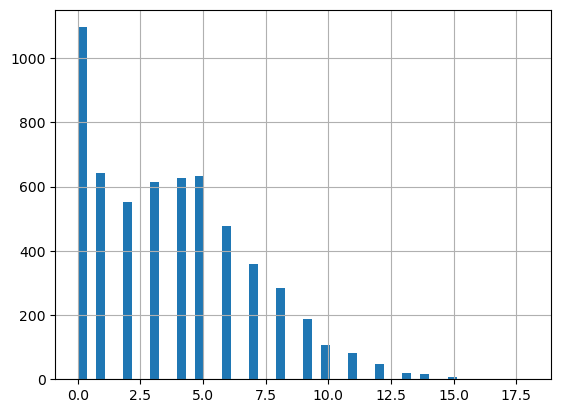

In [38]:
df[df['zone']==43]['demand'].hist(bins=50)